In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17515 entries, 0 to 17514
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17515 non-null  float64 
 1   latitude                  17515 non-null  float64 
 2   housing_median_age        17515 non-null  int8    
 3   total_rooms               17515 non-null  int16   
 4   total_bedrooms            17515 non-null  int16   
 5   population                17515 non-null  int16   
 6   households                17515 non-null  int16   
 7   median_income             17515 non-null  float64 
 8   median_house_value        17515 non-null  int32   
 9   ocean_proximity           17515 non-null  category
 10  median_income_cat         17515 non-null  int64   
 11  rooms_per_household       17515 non-null  float64 
 12  population_per_household  17515 non-null  float64 
 13  bedrooms_per_room         17515 non-null  float64 
 14  p

In [4]:
#Definir nossas colunas que serão preprocessadas
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [5]:
#Definir X e y
X = df.drop(columns = coluna_target)

y = df[coluna_target]

In [6]:
y

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700
...,...
17510,78100
17511,77100
17512,92300
17513,84700


In [7]:
#criar o preprocessamento

preprocessamento = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
    ],
    remainder='passthrough',
)

In [8]:
#criar o target transformer

power_transformer = PowerTransformer()

In [9]:
# Definindo noss modelos de treino para comparação

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_Power": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": power_transformer,
    },
}

In [10]:
#Treinar e validar modelos

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

resultados

{'DummyRegressor': {'fit_time': array([0.00671458, 0.00327921, 0.00374126, 0.0035913 , 0.00385618]),
  'score_time': array([0.00573516, 0.00560236, 0.00478745, 0.00514913, 0.00483274]),
  'test_r2': array([-8.79886502e-04, -7.01292589e-05, -3.90446967e-04, -1.07273469e-04,
         -1.34175423e-04]),
  'test_neg_mean_absolute_error': array([-76256.6430076 , -76449.68322658, -76241.74334592, -77052.4072976 ,
         -77839.12138232]),
  'test_neg_root_mean_squared_error': array([-95147.59926567, -96287.73388159, -95461.5544825 , -96172.37627931,
         -97119.54792537])},
 'LinearRegression': {'fit_time': array([0.02801228, 0.02647567, 0.02390361, 0.02386594, 0.02443337]),
  'score_time': array([0.01271796, 0.01691222, 0.01267028, 0.01376247, 0.0122602 ]),
  'test_r2': array([0.69028914, 0.66606835, 0.66104148, 0.6679513 , 0.66398948]),
  'test_neg_mean_absolute_error': array([-39415.65518174, -40876.66288459, -41414.43293308, -40450.64599389,
         -41326.95514596]),
  'test_neg_

In [11]:
#dataframe comparativo com os resultados de tempo e erros dos modelos para cada 'cross-validation'
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.006715,0.005735,-0.00088,-76256.643008,-95147.599266,0.01245
1,DummyRegressor,0.003279,0.005602,-0.00007,-76449.683227,-96287.733882,0.008882
2,DummyRegressor,0.003741,0.004787,-0.00039,-76241.743346,-95461.554483,0.008529
3,DummyRegressor,0.003591,0.005149,-0.000107,-77052.407298,-96172.376279,0.00874
4,DummyRegressor,0.003856,0.004833,-0.000134,-77839.121382,-97119.547925,0.008689
5,LinearRegression,0.028012,0.012718,0.690289,-39415.655182,-52927.949935,0.04073
6,LinearRegression,0.026476,0.016912,0.666068,-40876.662885,-55639.667647,0.043388
7,LinearRegression,0.023904,0.01267,0.661041,-41414.432933,-55567.007594,0.036574
8,LinearRegression,0.023866,0.013762,0.667951,-40450.645994,-55415.078057,0.037628
9,LinearRegression,0.024433,0.01226,0.663989,-41326.955146,-56292.942964,0.036694


In [12]:
#comparação das médias das métricas por modelo
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004237,0.005221,-0.000316,-76767.919652,-96037.762367,0.009458
LinearRegression,0.025338,0.013665,0.669868,-40696.870428,-55168.529239,0.039003
LinearRegression_Power,0.065962,0.015271,0.672073,-38844.095967,-54978.112514,0.081232


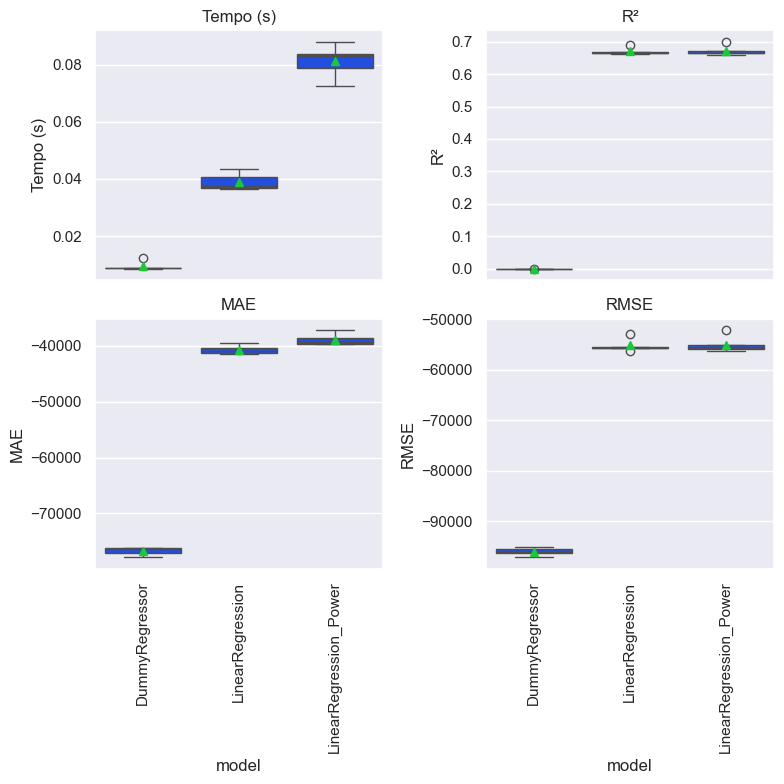

In [13]:
#gráfico comparativos das métricas de cada modelo
plot_comparar_metricas_modelos(df_resultados)

Podemos observar uma melhoria das métricas com o target transformer. A seguir vamos testar outro tipo de target transformer (Quantile Transformer)


In [14]:
quantile_transformer= QuantileTransformer(output_distribution='normal')

In [15]:
param_grid = {
    "transformer": [None, power_transformer, quantile_transformer]
}

In [16]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    param_grid=param_grid,
    preprocessor=preprocessamento,
    target_transformer=power_transformer,
)

grid_search

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [17]:
grid_search.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [18]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [19]:
grid_search.best_estimator_

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...egression())])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",QuantileTrans...tion='normal')
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('ordinal_encoder', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always r

In [20]:
grid_search.best_estimator_.transformer_

,"n_quantiles n_quantiles: int, default=1000 or n_samplesNumber of quantiles to be computed. It corresponds to the numberof landmarks used to discretize the cumulative distribution function.If n_quantiles is larger than the number of samples, n_quantiles is setto the number of samples as a larger number of quantiles does not givea better approximation of the cumulative distribution functionestimator.",1000
,"output_distribution output_distribution: {'uniform', 'normal'}, default='uniform'Marginal distribution for the transformed data. The choices are'uniform' (default) or 'normal'.",'normal'
,"ignore_implicit_zeros ignore_implicit_zeros: bool, default=FalseOnly applies to sparse matrices. If True, the sparse entries of thematrix are discarded to compute the quantile statistics. If False,these entries are treated as zeros.",False
,"subsample subsample: int or None, default=10_000Maximum number of samples used to estimate the quantiles forcomputational efficiency. Note that the subsampling procedure maydiffer for value-identical sparse and dense matrices.Disable subsampling by setting `subsample=None`... versionadded:: 1.5 The option `None` to disable subsampling was added.",10000
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for subsampling and smoothingnoise.Please see ``subsample`` for more details.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",None
,"copy copy: bool, default=TrueSet to False to perform inplace transformation and avoid a copy (if theinput is already a numpy array).",True


In [21]:
# Definindo noss modelos de treino para comparação

regressors2 = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_Power": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": power_transformer,
    },
     "LinearRegression_Quantile": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [22]:
#Treinar e validar modelos

resultados2 = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors2.items()
}

resultados2

{'DummyRegressor': {'fit_time': array([0.00595093, 0.00736761, 0.00528669, 0.00519919, 0.00514722]),
  'score_time': array([0.00622034, 0.0101819 , 0.00726652, 0.00720882, 0.00927567]),
  'test_r2': array([-8.79886502e-04, -7.01292589e-05, -3.90446967e-04, -1.07273469e-04,
         -1.34175423e-04]),
  'test_neg_mean_absolute_error': array([-76256.6430076 , -76449.68322658, -76241.74334592, -77052.4072976 ,
         -77839.12138232]),
  'test_neg_root_mean_squared_error': array([-95147.59926567, -96287.73388159, -95461.5544825 , -96172.37627931,
         -97119.54792537])},
 'LinearRegression': {'fit_time': array([0.03993893, 0.03187847, 0.03026104, 0.03026295, 0.0329802 ]),
  'score_time': array([0.02079988, 0.01547098, 0.01552701, 0.01677394, 0.01505709]),
  'test_r2': array([0.69028914, 0.66606835, 0.66104148, 0.6679513 , 0.66398948]),
  'test_neg_mean_absolute_error': array([-39415.65518174, -40876.66288459, -41414.43293308, -40450.64599389,
         -41326.95514596]),
  'test_neg_

In [23]:
#dataframe comparativo com os resultados de tempo e erros dos modelos para cada 'cross-validation'
df_resultados2 = organiza_resultados(resultados2)

df_resultados2

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005951,0.00622,-0.00088,-76256.643008,-95147.599266,0.012171
1,DummyRegressor,0.007368,0.010182,-0.00007,-76449.683227,-96287.733882,0.01755
2,DummyRegressor,0.005287,0.007267,-0.00039,-76241.743346,-95461.554483,0.012553
3,DummyRegressor,0.005199,0.007209,-0.000107,-77052.407298,-96172.376279,0.012408
4,DummyRegressor,0.005147,0.009276,-0.000134,-77839.121382,-97119.547925,0.014423
5,LinearRegression,0.039939,0.0208,0.690289,-39415.655182,-52927.949935,0.060739
6,LinearRegression,0.031878,0.015471,0.666068,-40876.662885,-55639.667647,0.047349
7,LinearRegression,0.030261,0.015527,0.661041,-41414.432933,-55567.007594,0.045788
8,LinearRegression,0.030263,0.016774,0.667951,-40450.645994,-55415.078057,0.047037
9,LinearRegression,0.03298,0.015057,0.663989,-41326.955146,-56292.942964,0.048037


In [24]:
#comparação das médias das métricas por modelo
df_resultados2.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00579,0.008031,-0.000316,-76767.919652,-96037.762367,0.013821
LinearRegression,0.033064,0.016726,0.669868,-40696.870428,-55168.529239,0.04979
LinearRegression_Power,0.084485,0.021352,0.672073,-38844.095967,-54978.112514,0.105837
LinearRegression_Quantile,0.058007,0.024944,0.679356,-38593.374072,-54364.167133,0.082952


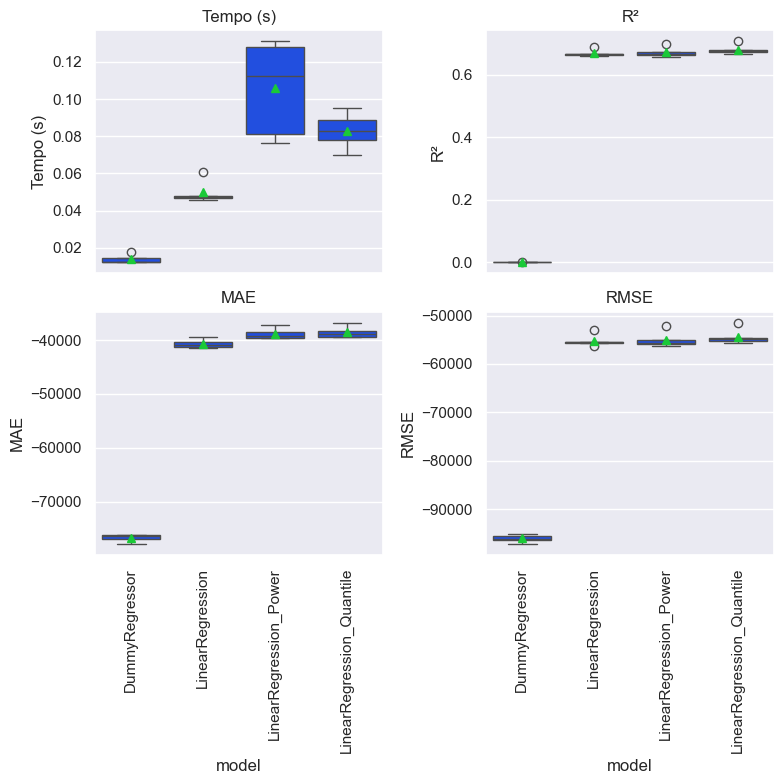

In [25]:
#gráfico comparativos das métricas de cada modelo
plot_comparar_metricas_modelos(df_resultados2)

Além de **melhorar as métricas de erro**, o modelo com **QuantileTransformer** melhorou o **tempo de treinamento** em relação ao modelo com o Power Transform

In [26]:
#coeficientes
grid_search.best_estimator_.regressor_['reg'].coef_

array([[-4.49894987e-01, -2.01154214e-01, -5.84299636e-02,
         3.76521871e-02, -3.00794534e-01, -2.94173090e-01,
         6.38753151e-03, -7.60412001e-05,  5.42125128e-06,
        -4.65534347e-05,  7.26635039e-04,  3.77735286e-01,
         1.81260339e-01, -4.81136161e-01,  2.51307906e+00,
         8.98603116e-01]])

In [27]:
#variáveis
grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()

array(['one_hot_encoder__ocean_proximity_INLAND',
       'one_hot_encoder__ocean_proximity_NEAR BAY',
       'one_hot_encoder__ocean_proximity_NEAR OCEAN',
       'ordinal_encoder__median_income_cat', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__total_rooms', 'remainder__total_bedrooms',
       'remainder__population', 'remainder__households',
       'remainder__median_income', 'remainder__rooms_per_household',
       'remainder__population_per_household',
       'remainder__bedrooms_per_room', 'remainder__population_per_room'],
      dtype=object)

In [28]:
#criando dataframe dos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
remainder__population_per_household,-0.481136
one_hot_encoder__ocean_proximity_INLAND,-0.449895
remainder__longitude,-0.300795
remainder__latitude,-0.294173
one_hot_encoder__ocean_proximity_NEAR BAY,-0.201154
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.058430
remainder__total_rooms,-0.000076
remainder__population,-0.000047
remainder__total_bedrooms,0.000005
remainder__households,0.000727


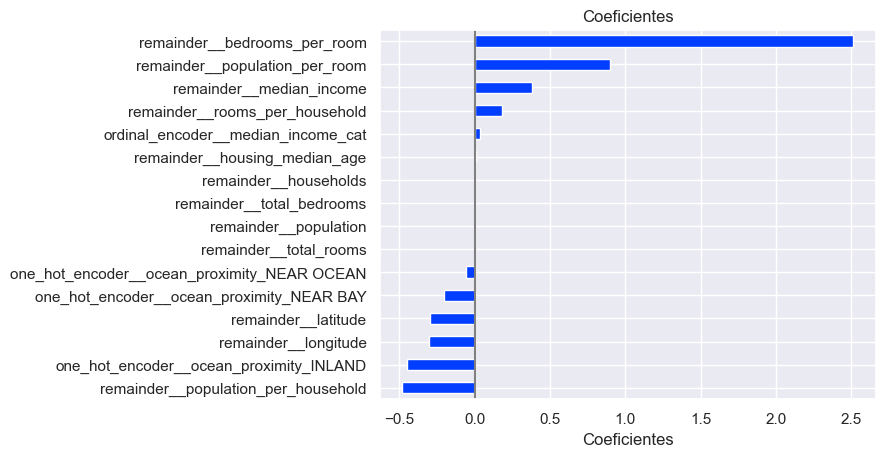

In [29]:
#analise gráfica do coeficiente do melhor modelo
plot_coeficientes(
    coefs, 
    tituto="Coeficientes")

Esse modelo valoriza casas com alta proporção de quartos em áreas de alta renda e densidade, e penaliza fortemente casas no interior do estado com muitas pessoas morando debaixo do mesmo teto.

Observe as variáveis no centro do gráfico (housing_median_age, households, total_bedrooms, population, total_rooms). Elas têm coeficientes quase iguais a zero.
O que isso significa? Isso prova que a  engenharia de recursos (Feature Engineering) foi um sucesso absoluto. O modelo percebeu que saber o número total de quartos em um quarteirão (total_bedrooms) não serve para prever o preço de uma casa. O que importa são as taxas e proporções criadas (como bedrooms_per_room). As variáveis brutas se tornaram redundantes e o modelo inteligentemente as ignorou.

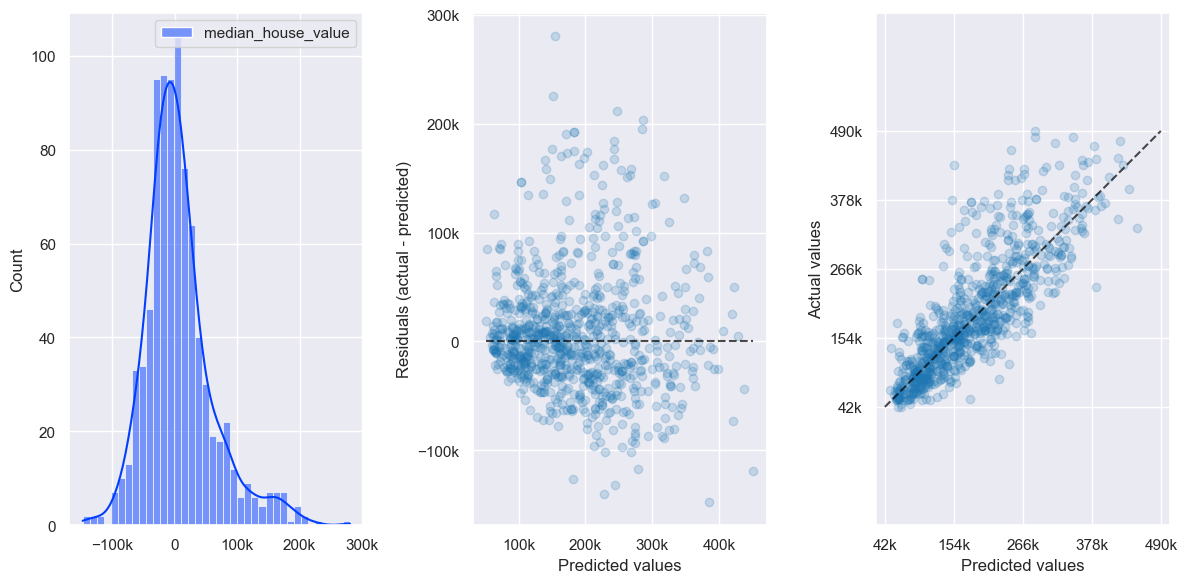

In [30]:
plot_residuos_estimador(
    grid_search.best_estimator_, 
    X, 
    y,
    fracao_amostra=0.05,
    eng_formatter=True
)

O grágico de resíduos mostra que o Modelo consegue prever os valor medio das casas com pequeno erro para a maior parte dos valores. E o modelo tem mais erros para uma valor menor que o valor real.